# Great Barrier Reef Competition notebook

This notebook is for the great barrier reef competition's dataset.The goal of this competition is to accurately identify starfish in real-time by building an object detection model trained on underwater videos of coral reefs.<br>
We will perform some augumentations to the underwater images to get stronger results.

Notebooks used as guidelines:
1. https://www.kaggle.com/code/soumya9977/learning-to-sea-underwater-img-enhancement-eda
2. https://www.kaggle.com/code/andradaolteanu/greatbarrierreef-yolo-full-guide-train-infer/notebook
3. https://www.kaggle.com/code/julian3833/reef-a-cv-strategy-subsequences/notebook
4. https://www.kaggle.com/code/andradaolteanu/greatbarrierreef-full-guide-to-bboxaugmentation/notebook

In [1]:
import os
import sys
import wandb
import torch
import sklearn
import random
import shutil
import yaml
import warnings
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html, display
from sklearn.model_selection import train_test_split, KFold
import logging

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'GreatBarrierReef', '_wandb_kernel': 'aot'}

### Install Yolo

In [2]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.1/715.1 kB 18.2 MB/s eta 0:00:0000:01


In [3]:
# WANDB login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb")

! wandb login $secret_value

Current Directory /kaggle/working
Notebook Color Scheme:


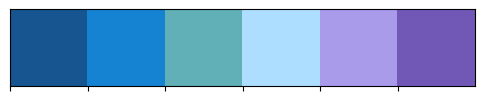

In [4]:
# Custom colors
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Current Directory"+color.E, os.getcwd())
print(color.S+"Notebook Color Scheme:"+color.E)
sns.palplot(sns.color_palette(my_colors))

In [5]:
# Set Random state, this is what we will use throughtout
RANDOM_STATE = 45

## Let's look at the training data

In [6]:
df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
train_dir = "../input/tensorflow-great-barrier-reef/train_images"
df[df.annotations.str.len()>2].head(5)

video_id  sequence  video_frame  sequence_frame image_id  \
16         0     40258           16              16     0-16   
17         0     40258           17              17     0-17   
18         0     40258           18              18     0-18   
19         0     40258           19              19     0-19   
20         0     40258           20              20     0-20   

                                          annotations  
16  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]  
17  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]  
18  [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]  
19  [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]  
20  [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]

In [7]:
# Let's add image path and number of annotations as additional columns to this data frame
df["annotations"] = df["annotations"].apply(eval)
df["no_of_bbox"] = df["annotations"].apply(lambda x : len(x))
df["image_path"] = train_dir + "/video_" + df["video_id"].astype(str) + "/" + df["video_frame"].astype(str) + ".jpg"

# Dataframe of non annotated data
df_train_v1 = df[df["no_of_bbox"] == 0].reset_index(drop=True)

display(df_train_v1.head(5))
# DataFrame of only annotated data
df_train = df[df["no_of_bbox"] > 0].reset_index(drop=True)

display(df_train.head(5))

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   no_of_bbox                                         image_path  
0           0  ../input/tensorflow-great-barrier-reef/train_i...  
1           0  ../input/tensorflow-great-barrier-reef/train_i...  
2           0  ../input/tensorflow-great-barrier-reef/train_i...  
3           0  ../input/tensorflow-great-barrier-reef/train_i...  
4           0  ../input/tensorflow-great-barrier-reef/train_i...

video_id  sequence  video_frame  sequence_frame image_id  \
0         0     40258           16              16     0-16   
1         0     40258           17              17     0-17   
2         0     40258           18              18     0-18   
3         0     40258           19              19     0-19   
4         0     40258           20              20     0-20   

                                         annotations  no_of_bbox  \
0  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]           1   
1  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]           1   
2  [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]           1   
3  [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]           1   
4  [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]           1   

                                          image_path  
0  ../input/tensorflow-great-barrier-reef/train_i...  
1  ../input/tensorflow-great-barrier-reef/train_i...  
2  ../input/tensorflow-great-barrier-reef/train_i...  
3  ../input/tensorflow-great-barrier-reef/train_i...  
4  ../input/tensorflow-great-barrier-reef/train_i...

In [8]:
# Let's see how much of the total data has annotations
total = len(df)
annotated = len(df_train)
non_annotated = len(df_train_v1)

print( color.S + f"Percentage of annotated images : " + color.E + str(round(((annotated/total)*100),2)) + "%")
print(color.S + "Annotated Images: " + color.E + str(annotated))
print(color.S + "Not Annotated Images: " + color.E + str(non_annotated))
print(color.S + "Total Images: " + color.E + str(total))

Percentage of annotated images : 20.93%
Annotated Images: 4919
Not Annotated Images: 18582
Total Images: 23501


## Split Strategy
Since we have very little data that actually has cots, we want to make sure that while measuring the model's performance we don't just end up validating of 5000 images without cots and the same background. I am going to use the entirety of the annotated  4919 images and we are also going to add in some of the iamegs that do not have the cots present in them.   
A good way to split the might be using the sequences  

### Here's some Math

According to Ultralytics best training tips for Yolo, 10% of data is reccomended to be background images. Here: https://docs.ultralytics.com/yolov5/tutorials/tips_for_best_training_results/#dataset<br>
Total = 4919 + 10% of Total<br>
So, Total = 5465 Images<br>
Annotated = 4919<br>
Background = 546<br>
<br>
We will perform a 80-20 split between train and val data. We will sample the 546 images evenly from the background data by using the Sequence as the sapmlping unit. The reason being we do not want the same part of the video being repeated too many times.  

In [9]:
print(color.S + "Total sequences: " + color.E + str(df_train_v1["sequence"].nunique()) )
df_train_v1["sequence"].unique()

Total sequences: 18


array([40258, 45518, 59337,  8399, 45015, 35305, 53708,   996, 60510, 44160, 15827, 29424,  8503, 60754, 37114, 26651, 22643, 29859])

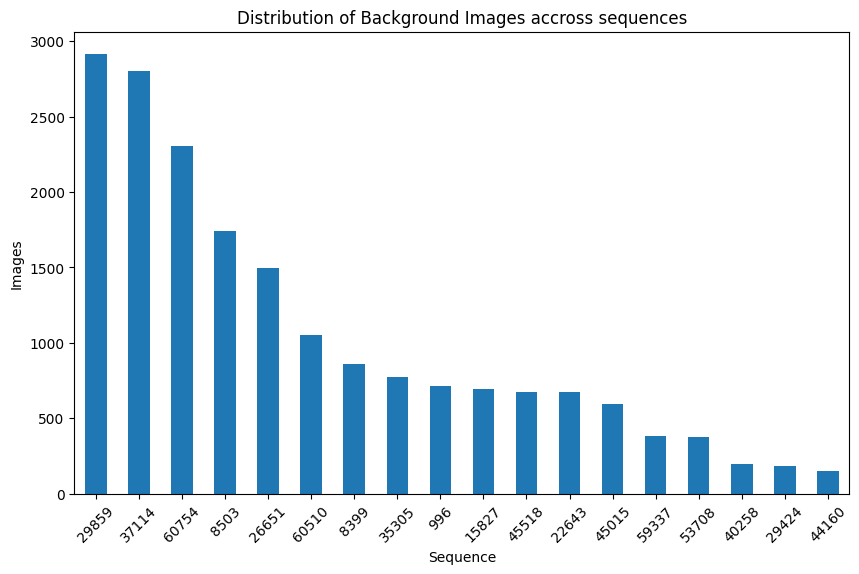

In [10]:
# Distribution of background in different sequences
dist = df_train_v1["sequence"].value_counts()

plt.figure(figsize=(10,6))
dist.plot(kind="bar")
plt.title("Distribution of Background Images accross sequences")
plt.xlabel("Sequence")
plt.ylabel("Images")
plt.xticks(rotation=45)
plt.show()

### Hmmmm
As we can see the sequences are not balanced. So we will sample this evenly using Sklearn. This is not required from the annotated images because we are going to use them all.<br>
We are going to add all these images together as one dataset and the perform K fold cross validation on them.

In [11]:
# Taking background images
# total_images = 546
total_images = 1000
dist = df_train_v1["sequence"].value_counts()
df_train_v2 = []


for sequence, count in dist.items():
    samples_to_take = int(total_images * (count / len(df_train_v1)))
    df_train_v2.append(df_train_v1[df_train_v1['sequence'] == sequence].sample(samples_to_take, random_state=RANDOM_STATE))

df_train_v3 = pd.concat(df_train_v2)
df_train_v3 = pd.DataFrame(df_train_v3)
df_train_v3 = df_train_v3.reset_index(drop=True)
print(color.S + "This is our background dataset of size: " + color.E + str(len(df_train_v3)))

This is our background dataset of size: 992


In [12]:
dataset = pd.concat([df_train, df_train_v3])
print(color.S + "This is our final dataset of size: " + color.E + str(len(dataset)))
display(dataset.head(5))

This is our final dataset of size: 5911


video_id  sequence  video_frame  sequence_frame image_id  \
0         0     40258           16              16     0-16   
1         0     40258           17              17     0-17   
2         0     40258           18              18     0-18   
3         0     40258           19              19     0-19   
4         0     40258           20              20     0-20   

                                         annotations  no_of_bbox  \
0  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]           1   
1  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]           1   
2  [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]           1   
3  [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]           1   
4  [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]           1   

                                          image_path  
0  ../input/tensorflow-great-barrier-reef/train_i...  
1  ../input/tensorflow-great-barrier-reef/train_i...  
2  ../input/tensorflow-great-barrier-reef/train_i...  
3  ../input/tensorflow-great-barrier-reef/train_i...  
4  ../input/tensorflow-great-barrier-reef/train_i...

In [13]:
del df, df_train, df_train_v1

# COCO to YOLO

First we need to add the annotations as usable coco format bboxes

In [17]:
# Add coco format box and height and width of the image
dataset["coco_bbox"] = dataset["annotations"].apply(lambda x: [list(item.values()) for item in x])
dataset['width']  = 1280
dataset['height'] = 720
display(dataset.head(5))

video_id  sequence  video_frame  sequence_frame image_id  \
0         0     40258           16              16     0-16   
1         0     40258           17              17     0-17   
2         0     40258           18              18     0-18   
3         0     40258           19              19     0-19   
4         0     40258           20              20     0-20   

                                         annotations  no_of_bbox  \
0  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]           1   
1  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]           1   
2  [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]           1   
3  [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]           1   
4  [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]           1   

                                          image_path             coco_bbox  \
0  ../input/tensorflow-great-barrier-reef/train_i...  [[559, 213, 50, 32]]   
1  ../input/tensorflow-great-barrier-reef/train_i...  [[558, 213, 50, 32]]   
2  ../input/tensorflow-great-barrier-reef/train_i...  [[557, 213, 50, 32]]   
3  ../input/tensorflow-great-barrier-reef/train_i...  [[556, 214, 50, 32]]   
4  ../input/tensorflow-great-barrier-reef/train_i...  [[555, 214, 50, 32]]   

   width  height  
0   1280     720  
1   1280     720  
2   1280     720  
3   1280     720  
4   1280     720

In [18]:
def coco2yolo(image_height, image_width, bboxes):
    """
    Converts a coco annotation format [xmin, ymin, w, h] to 
    the corresponding yolo format [xmid, ymid, w, h]
    appends yolo_boxes
    
    image_height: height of the original image
    image_width: width of the original image
    bboxes: coco boxes to be converted
    return : list of bounding boxes in yolo format
    
    """
    
    yolo_bboxes = np.array(bboxes).astype(float)
    
    # Normalize xmin, w
    yolo_bboxes[:, [0, 2]]= yolo_bboxes[:, [0, 2]]/ image_width
    # Normalize ymin, h
    yolo_bboxes[:, [1, 3]]= yolo_bboxes[:, [1, 3]]/ image_height
    
    # Converstion (xmin, ymin) => (xmid, ymid)
    yolo_bboxes[:, [0, 1]] = yolo_bboxes[:, [0, 1]] + yolo_bboxes[:, [2, 3]]/2
    
    # Clip values (between 0 and 1)
    yolo_bboxes = np.clip(yolo_bboxes, a_min=0, a_max=1)
    
    return yolo_bboxes

In [19]:
# --- Example ---
bbox_example = [[559, 213, 50, 32], [679, 223, 10, 100]]

print(color.S+"From COCO: "+color.E, bbox_example)
print(color.S+"to YOLO:"+color.E, 
      coco2yolo(image_height=720, 
                image_width=1280, 
                bboxes=bbox_example))

From COCO:  [[559, 213, 50, 32], [679, 223, 10, 100]]
to YOLO: [[    0.45625     0.31806    0.039062    0.044444]
 [    0.53438     0.37917   0.0078125     0.13889]]


In [20]:
# Convert the bboxes from coco to yolo
yolo_bboxes = []

for k in tqdm(range(len(dataset))):
    row_data = dataset.iloc[k,:]
    height = row_data["height"]
    width = row_data["width"]
    coco_box = row_data["coco_bbox"]
    len_bbox = row_data["no_of_bbox"]
    
    if len_bbox == 0:
        yolo_bboxes.append([])
    else:
        yolo_bbox = coco2yolo(height, width, coco_box)
        yolo_bboxes.append(yolo_bbox)

dataset["yolo_bbox"] = yolo_bboxes

100%|██████████| 5911/5911 [00:01<00:00, 5894.61it/s]


# Let's do this with Data Augmentation

#### We will need to format the annotations we have now:

Initial format: {'x': 628, 'y': 321, 'width': 42, 'height': 47}<br>
Formated annotations: {'x1': 628, 'y1': 321, 'x2': 670, 'y2': 368} => [628, 321, 670, 368]

In [21]:
def format_annotations(x):
    '''Changes annotations from format {x, y, width, height} to {x1, y1, x2, y2}.
    x: a string of the initial format.'''
    
    annotations = x
    new_annotations = []

    if annotations:
        for annot in annotations:
            new_annotations.append([annot["x"],
                                    annot["y"],
                                    annot["x"]+annot["width"],
                                    annot["y"]+annot["height"]
                                   ])
    
    if new_annotations: return str(new_annotations)
    else: return "[]"

In [ ]:
# Create a new column with the new formated annotations
dataset["f_annotations"] = dataset["annotations"].apply(lambda x: format_annotations(x))

In [ ]:
display(dataset.head(5))

In [ ]:
def show_image_bbox(img, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    img: the output from cv2.imread()
    annot: FORMATED annotation'''
    
    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    axs.imshow(img)

    if annot:
        for a in annot:
            rect = patches.Rectangle((a[0], a[1]), a[2]-a[0], a[3]-a[1], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")

### (Random) Horizontal Flip

In [ ]:
class RandomHorizontalFlip(object):

    def __init__(self, p=0.5):
        # p = probability of the image to be flipped
        # set p = 1 to always flip
        self.p = p
        
    def __call__(self, img, bboxes):
        '''img : the image to be flipped
        bboxes : the annotations within the image'''
        if len(bboxes) == 0:
            return img, bboxes
        # Convert bboxes
        bboxes = np.array(bboxes)
        
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        
        # If random number between 0 and 1 < probability p
        if random.random() < self.p:
            # Reverse image elements in the 1st dimension
            img =  img[:,::-1,:]
            bboxes[:,[0,2]] = bboxes[:,[0,2]] + 2*(img_center[[0,2]] - bboxes[:,[0,2]])
            
            # Convert the bounding boxes
            box_w = abs(bboxes[:,0] - bboxes[:,2])
            bboxes[:,0] -= box_w
            bboxes[:,2] += box_w
            
        return img, bboxes.tolist()

Let's test out the Horizontal flip function

In [ ]:
# Take an example
path = list(dataset[dataset["no_of_bbox"]==18]["image_path"])[0]

img_original = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
annot_original = eval(list(dataset[dataset["no_of_bbox"]==18]["f_annotations"])[0])

# Horizontal Flip
horizontal_flip = RandomHorizontalFlip(p=1)  
img_flipped, annot_flipped = horizontal_flip(img_original, annot_original)



# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Horizontal Flip", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("With Horizontal Flip", fontsize = 20)
show_image_bbox(img_flipped, annot_flipped, axs[1])

plt.tight_layout()
plt.show()

 ### (Random) Scaling

In [ ]:
# ==== Clips the bboxes ====
def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def clip_box(bbox, clip_box, alpha):
    """
    Clip the bounding boxes to the borders of an image
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox

In [ ]:
class RandomScale(object):

    def __init__(self, scale = 0.2, diff = False):
        
        # scale must always be a positive number
        self.scale = scale
        self.scale = (max(-1, -self.scale), self.scale)
        
        # Maintain the aspect ratio
        # (scaling factor remains the same for width & height)
        self.diff = diff
        
        
    def __call__(self, img, bboxes):
        
        if len(bboxes) == 0:
            return img, bboxes
        # Convert bboxes
        bboxes = np.array(bboxes)

        #Chose a random digit to scale by 
        img_shape = img.shape

        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x

        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y

        # Resize the image by scale factor
        img = cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)

        bboxes[:,:4] = bboxes[:,:4] * [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]

        # The black image (the remaining area after we have clipped the image)
        canvas = np.zeros(img_shape, dtype = np.uint8)

        # Determine the size of the scaled image
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])

        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]

        img = canvas
        # Adjust the bboxes - remove all annotations that dissapeared after the scaling
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)

        return img, bboxes.tolist()

In [ ]:
random.seed(RANDOM_STATE)

# Scaling
scale = RandomScale(scale=.7, diff = True) 
img_scaled, annot_scaled = scale(img_original, annot_original)



# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Image Scaling", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("Scaled (zoomed in) Image", fontsize = 20)
show_image_bbox(img_scaled, annot_scaled, axs[1])

plt.tight_layout()
plt.show()

### (Random) Translate

In [ ]:
class RandomTranslate(object):

    def __init__(self, translate = 0.2, diff = False):
        
        self.translate = translate
        self.translate = (-self.translate, self.translate)
            
        # Maintain the aspect ratio
        # (scaling factor remains the same for width & height)
        self.diff = diff
        
    def __call__(self, img, bboxes):  
        
        if len(bboxes) == 0:
            return img, bboxes
        # Convert bboxes
        bboxes = np.array(bboxes)
        
        # Chose a random digit to scale by 
        img_shape = img.shape

        # Percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)

        if not self.diff:
            translate_factor_y = translate_factor_x

        canvas = np.zeros(img_shape).astype(np.uint8)

        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])

        #Change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]

        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas

        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]

        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)

        return img, bboxes.tolist()

In [ ]:
random.seed(RANDOM_STATE)

# Translate
translate = RandomTranslate(translate=0.4, diff = False) 
img_translated, annot_translated = translate(img_original, annot_original)



# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Image Translation", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("Translated (shifted) Image", fontsize = 20)
show_image_bbox(img_translated, annot_translated, axs[1])

plt.tight_layout()
plt.show()

### (Random) Rotation
This bit is a little tricky. Cause we can't simply rotate the bounding boxes. Instead we have to make new bounding boxes that cover the rotated object.

In [ ]:
# === Image Rotation ===

def rotate_im(image, angle):
    '''image: numpy array of the image'''
    '''angle: a float that specifies the angle the image should be rotated.'''

    # Image dimensions
    (h, w) = image.shape[:2]
    # Image Centre
    (cX, cY) = (w // 2, h // 2)

    # Rotation Matrix from cv2
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    # Sine & Cosine - rotation components of the matrix
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # NEW Bounding Dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform the Rotation
    image = cv2.warpAffine(image, M, (nW, nH))

    return image

In [ ]:
# Functions for BBox Rotation

def get_corners(bboxes):
    '''bboxes: array of the original bounding boxes.'''
    
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    # Each bounding box is described by 8 coordinates x1,y1,x2,y2,x3,y3,x4,y4
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners


# === Box Rotation ===

def rotate_box(corners, angle, cx, cy, h, w):
    '''
    corners: output from get_corners()
    angle:  a float that specifies the angle the image should be rotated
    cx, cy: coordinates for the xenter of the image
    h, w: height and width of the image
    '''
    
    # corners = x1,y1,x2,y2,x3,y3,x4,y4
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    # Rotation Matrix from cv2
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    # Sine & Cosine - rotation components of the matrix
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # NEW Bounding Dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    calculated = calculated.reshape(-1,8)
    
    return calculated


# === Get the Enclosing Box ===

def get_enclosing_box(corners):
    '''corners: output from get_corners()'''
    
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    # Notation where each bounding box is determined by 4 coordinates or two corners
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

In [ ]:
class RandomRotate(object):

    def __init__(self, angle = 10):
        
        self.angle = angle
        self.angle = (-self.angle, self.angle)
        
        
    def __call__(self, img, bboxes):
        
        if len(bboxes) == 0:
            return img, bboxes
        # Convert bboxes
        bboxes = np.array(bboxes)
        
        # Compute the random angle
        angle = random.uniform(*self.angle)

        # width, height and center of the image
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2

        # Rotate the image
        img = rotate_im(img, angle)

        # --- Rotate the bounding boxes ---
        # Get the 4 point corner coordinates
        corners = get_corners(bboxes)
        corners = np.hstack((corners, bboxes[:,4:]))
        # Rotate the bounding box
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        # Get the enclosing (new bboxes)
        new_bbox = get_enclosing_box(corners)

        # Get scaling factors to clip the image and bboxes
        scale_factor_x = img.shape[1] / w
        scale_factor_y = img.shape[0] / h

        # Rescale the image - to w,h and not nW,nH
        img = cv2.resize(img, (w,h))

        # Clip boxes (in case there are any outside of the rotated image)
        bboxes[:,:4] = bboxes[:,:4] / [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)

        return img, bboxes.tolist()

In [ ]:
random.seed(RANDOM_STATE)

# Translate
rotate = RandomRotate(angle=25) 
img_rotated, annot_rotated = rotate(img_original, annot_original)



# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Image Rotation", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("Rotated Image", fontsize = 20)
show_image_bbox(img_rotated, annot_rotated, axs[1])

plt.tight_layout()
plt.show()

### (Random) Shearing

In [ ]:
class RandomShear(object):

    def __init__(self, shear_factor = 0.2):
        
        self.shear_factor = shear_factor
#         self.shear_factor = (-self.shear_factor, self.shear_factor)
        
#         shear_factor = random.uniform(*self.shear_factor)
        
        
    def __call__(self, img, annot_bboxes):
        
        if len(annot_bboxes) == 0:
            return img, annot_bboxes
        # Convert bboxes
        bboxes = np.array(annot_bboxes)

        # Get the shear factor and size of the image
        shear_factor = random.uniform(0.01,self.shear_factor)
        w,h = img.shape[1], img.shape[0]

        # Flip the image and boxes horizontally
        HorizontalFlip = RandomHorizontalFlip(p=1) 
        if shear_factor < 0:
            img, bboxes = HorizontalFlip(img, bboxes)

        # Apply the shear transformation
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])

        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * shear_factor).astype(int) 

        # Transform using cv2 warpAffine (like in rotation)
        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))

        # Flip the image back again
        if shear_factor < 0:
            img, bboxes = HorizontalFlip(img, bboxes)

        # Resize
        img = cv2.resize(img, (w,h))

        scale_factor_x = nW / w
        bboxes[:,:4] = bboxes[:,:4] / [scale_factor_x, 1, scale_factor_x, 1] 
        del HorizontalFlip
        
        return img, bboxes.tolist()

In [ ]:
random.seed(25)

# Translate
shear = RandomShear(shear_factor=0.9) 
img_sheared, annot_sheared = shear(img_original, annot_original)



# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Image Shear", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("Sheared Image", fontsize = 20)
show_image_bbox(img_sheared, annot_sheared, axs[1])

plt.tight_layout()
plt.show()

### Let's split the dataset

In [22]:
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=RANDOM_STATE)

# Output the shapes of train and test sets
print("Train set shape:", train_data.shape)
print("Test set shape:", val_data.shape)

Train set shape: (4728, 12)
Test set shape: (1183, 12)


## Create the required directories

In [23]:
print(color.S+"-Directory Structure-"+color.E)
print(color.S+"Before:"+color.E, os.listdir("../"))

# Create 2 new folders 
!mkdir -p 'data/images'
!mkdir -p 'data/labels'

print(color.S+"After:"+color.E, os.listdir("data"))

-Directory Structure-
Before: ['lib', 'input', 'working']
After: ['labels', 'images']


In [24]:
# Add train and val to labels and images
!mkdir -p 'data/images/train'
!mkdir -p 'data/images/val'

!mkdir -p 'data/labels/train'
!mkdir -p 'data/labels/val'

print(color.S+"/images:"+color.E, os.listdir("data/images"))
print(color.S+"/labels:"+color.E, os.listdir("data/labels"))

/images: ['train', 'val']
/labels: ['train', 'val']


In [25]:
# Set directories
root_dir="/kaggle/working/data"
labels_dir="/kaggle/working/data/labels"
images_dir="/kaggle/working/data/images" 

## Add data to directories without Augumentation

In [26]:
train_count = 0
val_count = 0
for path in tqdm(train_data["image_path"].tolist()):
    split_path = path.split("/")
    
    video_id = split_path[-2]
    video_frame = split_path[-1]
    dest_path = f"data/images/train/{video_id}_{video_frame}"
    train_count = train_count + 1
        
    shutil.copy(src=path, dst=dest_path)

for path in tqdm(val_data["image_path"].tolist()):
    split_path = path.split("/")
    
    video_id = split_path[-2]
    video_frame = split_path[-1]
    dest_path = f"data/images/val/{video_id}_{video_frame}"
    val_count = val_count + 1
        
    shutil.copy(src=path, dst=dest_path)

print(f"{train_count} files added to train")
print(f"{val_count} files added to val")

100%|██████████| 1183/1183 [00:17<00:00, 65.85it/s]

4728 files added to train
1183 files added to val


In [ ]:
display(train_data.head(30))

## Add data to directories with augumentation

#### Function to covert formatted annotations to yolo annotations

In [ ]:
def convert_to_yolo_format(annotations, image_width, image_height):
    yolo_annotations = []
    for x1, y1, x2, y2 in annotations:
        # Calculate bounding box center coordinates
        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
        
        # Calculate bounding box width and height
        width = x2 - x1
        height = y2 - y1
        
        # Normalize coordinates and dimensions by image width and height
        x_center_norm = x_center / image_width
        y_center_norm = y_center / image_height
        width_norm = width / image_width
        height_norm = height / image_height
        
        # Append YOLO format annotation to the list
        yolo_annotations.append([x_center_norm, y_center_norm, width_norm, height_norm])
    
    return yolo_annotations

# Example annotations list in (x1, y1, x2, y2) format
annotations_list = eval(train_data.iloc[2,:]["f_annotations"])
print(color.S + "Yolo value from Dataframe: " + color.E)
print(train_data.iloc[2,:]["yolo_bbox"])

# Example image dimensions
image_width = 1280
image_height = 720

# Convert annotations to YOLO format
yolo_annotations_list = convert_to_yolo_format(annotations_list, image_width, image_height)
print(color.S + "Yolo value from our function: " + color.E)
print(yolo_annotations_list)

In [ ]:
train_images = os.listdir("/kaggle/working/data/images/train")

train_count = 0

for image in train_images:
        image_path = os.path.join("/kaggle/working/data/images/train", image)
        train_count = train_count + 1
        os.remove(image_path)
print(train_count)

In [ ]:
# Augument train data and save it in train directory
aug_bboxes = []

hflip_p=0.45
scale_p=0.25
translate_p=0.15
shearing_p=0.15

aug_bboxes = []
# # I am going to add 15% of the augumented data
# ADD = 0.15

random.seed(RANDOM_STATE)
count = 0

for k in tqdm(range(len(train_data))):
# for k in range(40):

    # add = False
    # Load image and annotations
    row = train_data.iloc[k,:]
    path = row["image_path"]
    split_path = path.split("/")
    video_id = split_path[-2]
    video_frame = split_path[-1]
    dest_path = f"data/images/train/{video_id}_{video_frame}"
    len_bbox = row["no_of_bbox"]
    if len_bbox > 0:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annot = eval(row["f_annotations"])

        # Find probabilities
        aug1 = random.random()
        aug2 = random.random()
        flip = random.random() < hflip_p
        scale = random.random() < scale_p
        translate =  aug1 < translate_p
        shear = aug2 < shearing_p
    
        #     if flip or translate or scale or shear:
        #     add = random.random() < 0.15

        if flip:
            horizontal_flip = RandomHorizontalFlip(p=1)  
            image, annot = horizontal_flip(image, annot)
            del horizontal_flip

        if scale:
            scaling = RandomScale(scale=random.uniform(0,0.35), diff = False)  
            image, annot = scaling(image, annot)
            del scaling

#         mult_aug = translate and shear
#         if mult_aug:
#             if aug1>aug2:
#                 translated = RandomTranslate(translate=random.uniform(0,0.45), diff = False) 
#                 image, annot = translated(image, annot)
#                 del translated
#             else:
#                 sheared = RandomShear(shear_factor=random.uniform(0,0.5)) 
#                 image, annot = sheared(image, annot)
#                 del sheared
        else:
            if translate:
                translated = RandomTranslate(translate=random.uniform(0,0.25), diff = False) 
                image, annot = translated(image, annot)
                del translated
#             if shear:
#                 sheared = RandomShear(shear_factor=0.6) 
#                 image, annot = sheared(image, annot)
#                 del sheared
            
            # if add:
            #     print("Add")
        cv2.imwrite(dest_path,image)
        if len(annot) == 0:
            aug_bboxes.append([])
        else:
            aug_bbox = convert_to_yolo_format(annot,1280, 720)
            aug_bboxes.append(aug_bbox)   
    else:   
        aug_bboxes.append([])
        shutil.copy(src=path, dst=dest_path)
    
    count = count + 1


train_data["aug_bbox"] = aug_bboxes
print(color.S + "Train images added: " + color.E + f"{count}")

In [ ]:
# Same thing for val directory

# Augument val data and save it in val directory
aug_bboxes = []

hflip_p=0.45
scale_p=0.25
translate_p=0.15
shearing_p=0.15

aug_bboxes = []
# # I am going to add 15% of the augumented data
# ADD = 0.15

random.seed(RANDOM_STATE)
count = 0

for k in tqdm(range(len(val_data))):
# for k in range(40):

    # add = False
    # Load image and annotations
    row = val_data.iloc[k,:]
    path = row["image_path"]
    split_path = path.split("/")
    video_id = split_path[-2]
    video_frame = split_path[-1]
    dest_path = f"data/images/val/{video_id}_{video_frame}"
    len_bbox = row["no_of_bbox"]
    if len_bbox > 0:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annot = eval(row["f_annotations"])

        # Find probabilities
        aug1 = random.random()
        aug2 = random.random()
        flip = random.random() < hflip_p
        scale = random.random() < scale_p
        translate =  aug1 < translate_p
        shear = aug2 < shearing_p
    
        #     if flip or translate or scale or shear:
        #     add = random.random() < 0.15

        if flip:
            horizontal_flip = RandomHorizontalFlip(p=1)  
            image, annot = horizontal_flip(image, annot)
            del horizontal_flip

        if scale:
            scaling = RandomScale(scale=random.uniform(0,0.35), diff = False)  
            image, annot = scaling(image, annot)
            del scaling

#         mult_aug = translate and shear
#         if mult_aug:
#             if aug1>aug2:
#                 translated = RandomTranslate(translate=random.uniform(0,0.45), diff = False) 
#                 image, annot = translated(image, annot)
#                 del translated
#             else:
#                 sheared = RandomShear(shear_factor=random.uniform(0,0.5)) 
#                 image, annot = sheared(image, annot)
#                 del sheared
        else:
            if translate:
                translated = RandomTranslate(translate=random.uniform(0,0.25), diff = False) 
                image, annot = translated(image, annot)
                del translated
#             if shear:
#                 sheared = RandomShear(shear_factor=0.6) 
#                 image, annot = sheared(image, annot)
#                 del sheared
            
            # if add:
            #     print("Add")
        cv2.imwrite(dest_path,image)
        if len(annot) == 0:
            aug_bboxes.append([])
        else:
            aug_bbox = convert_to_yolo_format(annot,1280, 720)
            aug_bboxes.append(aug_bbox)   
    else:   
        aug_bboxes.append([])
        shutil.copy(src=path, dst=dest_path)
    
    count = count + 1


val_data["aug_bbox"] = aug_bboxes
print(color.S + "Val images added: " + color.E + f"{count}")

### Adding the annotations to the labels dir 

In [ ]:
display(train_data.iloc[24,:]["aug_bbox"])

## Add labels with no sepatate augumentations

In [27]:
train_count = 0
val_count = 0

for k in tqdm(range(len(train_data))):
    row = train_data.iloc[k,:]
    len_bbox = len(row["yolo_bbox"])
    video_id = row["video_id"]
    video_frame = row["video_frame"]
    label_path = f"data/labels/train/video_{video_id}_{video_frame}.txt"
    train_count = train_count + 1 
    with open(label_path, "w") as file:
        if len_bbox == 0: 
            file.write("")
            continue
        yolo_bbox = row["yolo_bbox"]
        for i in range(len_bbox):       
            annot = ["0"] + \
                    yolo_bbox[i].astype(str).tolist() + \
                    ([""] if i+1 == len_bbox else ["\n"])
            annot = " ".join(annot).strip()
            file.write(annot)
            
print(f"{train_count} label files added to train")

for k in tqdm(range(len(val_data))):
    row = val_data.iloc[k,:]
    len_bbox = len(row["yolo_bbox"])
    
    video_id = row["video_id"]
    video_frame = row["video_frame"]
    label_path = f"data/labels/val/video_{video_id}_{video_frame}.txt"
    val_count = val_count + 1 
    with open(label_path, "w") as file:
        if len_bbox == 0: 
            file.write("")
            continue
        yolo_bbox = row["yolo_bbox"]
        for i in range(len_bbox):       
            annot = ["0"] + \
                    yolo_bbox[i].astype(str).tolist() + \
                    ([""] if i+1 == len_bbox else ["\n"])
            annot = " ".join(annot).strip()
            file.write(annot)

print(f"{val_count} lable files added to val")

100%|██████████| 4728/4728 [00:01<00:00, 4184.63it/s]


4728 label files added to train


100%|██████████| 1183/1183 [00:00<00:00, 4158.38it/s]

1183 lable files added to val


## Add labels with augumentations

In [ ]:
train_count = 0
val_count = 0

for k in tqdm(range(len(train_data))):
    row = train_data.iloc[k,:]
    len_bbox = len(row["aug_bbox"])
    video_id = row["video_id"]
    video_frame = row["video_frame"]
    label_path = f"data/labels/train/video_{video_id}_{video_frame}.txt"
    train_count = train_count + 1 
    with open(label_path, "w") as file:
        if len_bbox == 0: 
            file.write("")
            continue
        yolo_bbox = np.array(row["aug_bbox"])
        an = ""
        for i in range(len_bbox):
            annot = yolo_bbox[i].astype(str).tolist()
            annot =  "0 " + " ".join(annot).strip() + "\n"
            an = an + annot
        file.write(an)
            
print(f"{train_count} label files added to train")

for k in tqdm(range(len(val_data))):
    row = val_data.iloc[k,:]
    len_bbox = len(row["aug_bbox"])
    
    video_id = row["video_id"]
    video_frame = row["video_frame"]
    label_path = f"data/labels/val/video_{video_id}_{video_frame}.txt"
    val_count = val_count + 1 
    with open(label_path, "w") as file:
        if len_bbox == 0: 
            file.write("")
            continue
        yolo_bbox = np.array(row["aug_bbox"])
        an = ""
        for i in range(len_bbox):
            annot = yolo_bbox[i].astype(str).tolist()
            annot =  "0 " + " ".join(annot).strip() + "\n"
            an = an + annot
        file.write(an)
        
#             annot = ["0"] + \
#                     yolo_bbox[i].astype(str).tolist() + \
#                     ([""] if i+1 == len_bbox else ["\n"])
#             annot = " ".join(annot).strip()
#             file.write(annot)

print(f"{val_count} lable files added to val")

In [28]:
# Let's check a sample the labels
files = os.listdir("data/labels/train")
files2 = os.listdir("data/images/train")[:3]
print(len(os.listdir("data/labels/train")))
print(len(os.listdir("data/images/train")))
imgs = os.listdir("data/images/train")
for f in files:
    i = f[:-3]
    i = i+ 'jpg'
    if i not in imgs:
        print(f"Label file {f} does not have corresponsding images {i}")

files = os.listdir("data/labels/train")[:3]
  
print(color.S+"Sample of 3 labels from the data/labels/train folder:"+color.E, files, "\n")
for file in files:
    f = open(f"data/labels/train/{file}", 'r')
    print(color.S+f"{file}: "+color.E, f.read())

4728
4728
Sample of 3 labels from the data/labels/train folder: ['video_1_9174.txt', 'video_1_4102.txt', 'video_0_63.txt'] 

video_1_9174.txt:  0 0.375390625 0.4361111111111111 0.03515625 0.055555555555555550 0.1796875 0.8736111111111111 0.0640625 0.086111111111111110 0.466796875 0.9520833333333334 0.06484375 0.093055555555555560 0.421875 0.9597222222222221 0.0546875 0.077777777777777780 0.15351562500000002 0.6361111111111111 0.04453125 0.066666666666666670 0.08867187500000001 0.670138888888889 0.03203125 0.051388888888888890 0.332421875 0.3819444444444444 0.02734375 0.047222222222222220 0.2796875 0.1375 0.03125 0.03611111111111111
video_1_4102.txt:  0 0.69609375 0.029166666666666667 0.0359375 0.038888888888888890 0.413671875 0.10555555555555554 0.01953125 0.03611111111111111
video_0_63.txt:  0 0.465234375 0.8347222222222223 0.11015625 0.175


## ** DO NOT RUN **

In [ ]:
# Code to remove all train files

train_images = os.listdir("/kaggle/working/data/images/train")
val_images = os.listdir("/kaggle/working/data/images/val")

train_labels = os.listdir("/kaggle/working/data/labels/train")
val_labels = os.listdir("/kaggle/working/data/labels/val")

train_count = 0
val_count = 0

for image, label in zip(train_images, train_labels):
        image_path = os.path.join("/kaggle/working/data/images/train", image)
        label_path = os.path.join("/kaggle/working/data/labels/train", label)
        train_count = train_count + 1
        os.remove(image_path)
        os.remove(label_path)
print(f"{train_count} files removed from each train folder")

for image, label in zip(val_images, val_labels):
        image_path = os.path.join("/kaggle/working/data/images/val", image)
        label_path = os.path.join("/kaggle/working/data/labels/val", label)
        val_count = val_count + 1
        os.remove(image_path)
        os.remove(label_path)
print(f"{val_count} files removed from each val folder")

## Let's visualize a sample of the data

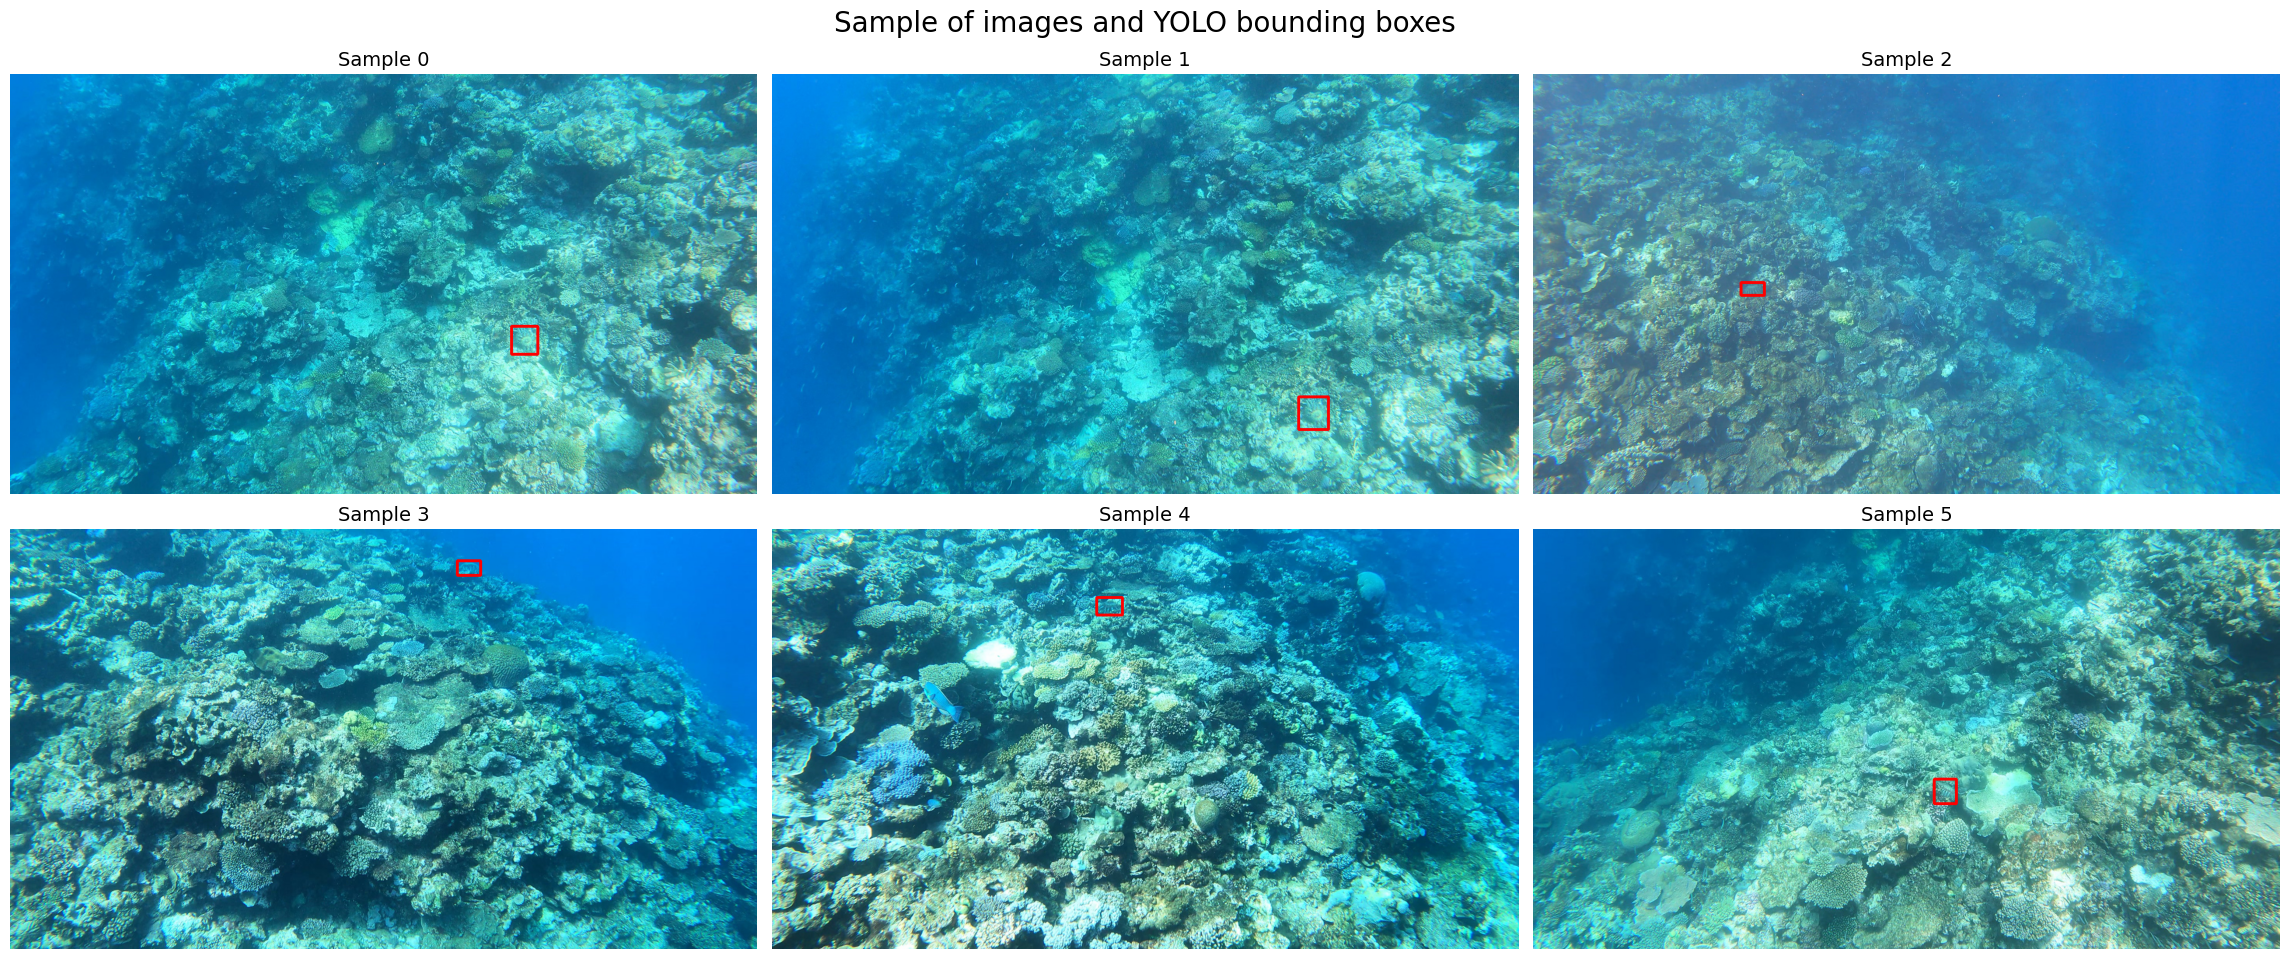

In [29]:
# Retrieve sample of data
images = os.listdir("data/images/train")
images = [image for image in]
vid_id = [im.split("_")[1] for im in images]
seq_id = [im.split("_")[2].split(".")[0] for im in images]

#Plot 
fig, axs = plt.subplots(2,3, figsize=(23,10))
axs = axs.flatten()
fig.suptitle(f"Sample of images and YOLO bounding boxes", fontsize = 20)

for idx,img in enumerate(images):
    #Get image and label
    
    im = cv2.imread(f"data/images/train/{img}")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    dh, dw, _ = im.shape
    txt = open(f"data/labels/train/{img[:-3]}txt","r").read().split(" ")[1:]
    no_boxes = int(len(txt)/4)
    
    i = 0
    while i < no_boxes:
        i = i+4
        box = txt[:i][-4:]
        
        # Src: https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # from YOLO to COCO
        x, y, w, h = box
        x, y, w, h = float(x), float(y), float(w), float(h)

        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        if l < 0: l = 0
        if r > dw - 1: r = dw - 1
        if t < 0: t = 0
        if b > dh - 1: b = dh - 1

        cv2.rectangle(im, (l, t), (r, b), (255,0,0), 3)

    # Show image with bboxes
    axs[idx].set_title(f"Sample {idx}", fontsize = 14)
    axs[idx].imshow(im)
    axs[idx].set_axis_off()

plt.tight_layout()
plt.show()

# Training

In [31]:
yolo_format=dict(path="/kaggle/working/data",
                 train="/kaggle/working/data/images/train",
                 val="/kaggle/working/data/images/val",
                 nc=1,
                 names={0:"cots"})

with open('/kaggle/working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

## Train without augumentation

In [33]:

# Set 1: Mean Average Precision @ .95 : 0.5511987644887244
# Mean Average Precision @ .50   : 0.8095559441344778
# Mean Average Precision @ .70   : 0.6453660616189637
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             flipud=0.3,
#             erasing=0.05,
#             hsv_h=0.0,
#             hsv_s=0.1,
#             hsv_v=0.1,
#             lr0=0.00075,
#             optimizer='Adam',
#             workers=4,
#             dropout=0.15)


# Set 2: Mean Average Precision @ .95 : 0.272 
# Mean Average Precision @ .50   : 0.131
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             lr0=0.0005,
#             workers=4,
#             dropout=0.25)


# Set 3: Mean Average Precision @.5:.95 : 0.6613159794191721
# Mean Average Precision @ .50   : 0.9076539168676862
# Mean Average Precision @ .70   : 0.7561004349890088
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             hsv_h=0.0,
#             hsv_s=0.1,
#             hsv_v=0.1,
#             lr0=0.0005,
#             optimizer='Adam',
#             workers=4,
#             dropout=0.25)

# Set 4:
# Mean Average Precision @.5:.95 : 0.5389383933484674
# Mean Average Precision @ .50   : 0.8802149324290104
# Mean Average Precision @ .70   : 0.5989967767957728
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             pretrained= False,
#             epochs=20,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             hsv_h=0.0,
#             hsv_s=0.0,
#             hsv_v=0.0,
#             lr0=0.0005,
#             degrees=60, 
#             translate=0.1, 
#             scale=0.35,   
#             shear=0.15,   
#             optimizer='AdamW',
#             workers=4,
#             dropout=0.25)

# Set 5
# Mean Average Precision @.5:.95 : 0.4649497714458981
# Mean Average Precision @ .50   : 0.7485644018018262
# Mean Average Precision @ .70   : 0.49941961753023695 

# Precision: 0.9017595307917888
# Recall': 0.6294779938587513

model=YOLO('yolov8s.pt')
model.train(data="/kaggle/working/yolo.yaml",
            seed=RANDOM_STATE,
            pretrained= False,
            optimizer='Adam',
            epochs=20,
            patience=5,
            batch=4,
            lr0=0.0005,
            imgsz=640,
            flipud=0.3,
            erasing=0.1,
            hsv_h=0.0,
            hsv_s=0.0,
            hsv_v=0.0,
            degrees=60, 
            translate=0.1, 
            scale=0.25,   
            shear=0.15,
            close_mosaic=20,
            workers=4,
            dropout=0.2,
            conf=0.55,
            plots=True )

Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/yolo.yaml, epochs=20, time=None, patience=5, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train3, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=45, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=20, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=0.55, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 6.23M/6.23M [00:00<00:00, 107MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/labels/train... 4728 images, 786 backgrounds, 0 corrupt: 100%|██████████| 4728/4728 [00:03<00:00, 1205.30it/s]


train: New cache created: /kaggle/working/data/labels/train.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1718, len(boxes) = 3942. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/labels/val... 1183 images, 206 backgrounds, 0 corrupt: 100%|██████████| 1183/1183 [00:01<00:00, 1116.61it/s]


val: New cache created: /kaggle/working/data/labels/val.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 400, len(boxes) = 977. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.34G      2.155      3.813      2.015          2        640: 100%|██████████| 1182/1182 [02:32<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.99it/s]

                   all       1183        977          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.46G      1.918      3.181      1.788          4        640: 100%|██████████| 1182/1182 [02:22<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 12.24it/s]

                   all       1183        977          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.44G      1.816      2.914      1.697          3        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.31it/s]

                   all       1183        977      0.433     0.0133      0.222     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.46G      1.737      2.728      1.642          4        640: 100%|██████████| 1182/1182 [02:22<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 12.24it/s]

                   all       1183        977          1    0.00307      0.502      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.45G      1.703      2.569      1.603          4        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.63it/s]

                   all       1183        977      0.273      0.111      0.174     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.46G      1.632      2.341      1.566          4        640: 100%|██████████| 1182/1182 [02:23<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.13it/s]

                   all       1183        977        0.8     0.0368      0.417      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.44G      1.586      2.159      1.533          4        640: 100%|██████████| 1182/1182 [02:26<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.75it/s]

                   all       1183        977      0.936      0.045      0.491      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.46G      1.543      2.014      1.485          2        640: 100%|██████████| 1182/1182 [02:24<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.55it/s]

                   all       1183        977      0.713      0.158      0.417      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.45G      1.508      1.886      1.464          3        640: 100%|██████████| 1182/1182 [02:22<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.74it/s]

                   all       1183        977       0.49      0.206      0.298      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.46G      1.461      1.684      1.439          1        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.18it/s]

                   all       1183        977      0.786      0.356      0.565      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.44G      1.417      1.541      1.411          4        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.36it/s]

                   all       1183        977      0.581      0.347      0.413      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.46G      1.378      1.456      1.379          3        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.44it/s]


                   all       1183        977      0.758      0.379      0.565      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.45G      1.324      1.322      1.345          4        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.41it/s]

                   all       1183        977      0.662      0.405       0.48      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.46G      1.298       1.23       1.32          4        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.20it/s]

                   all       1183        977      0.842      0.394      0.602      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.46G      1.243      1.126      1.283          2        640: 100%|██████████| 1182/1182 [02:23<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.28it/s]

                   all       1183        977      0.674      0.507      0.548       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.46G      1.198      1.048       1.25          3        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.20it/s]

                   all       1183        977      0.823      0.533      0.646      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.46G      1.176     0.9836      1.235          2        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.75it/s]

                   all       1183        977      0.789      0.514      0.606      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.46G      1.136     0.9147      1.215          2        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.64it/s]

                   all       1183        977      0.862      0.627       0.72      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.46G      1.086     0.8539      1.186          2        640: 100%|██████████| 1182/1182 [02:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.71it/s]

                   all       1183        977      0.902      0.631       0.75      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.44G      1.057     0.8002      1.158          3        640: 100%|██████████| 1182/1182 [02:22<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:12<00:00, 11.64it/s]

                   all       1183        977      0.845       0.64       0.71      0.445



20 epochs completed in 0.875 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:13<00:00, 11.21it/s]


                   all       1183        977      0.902      0.629      0.749      0.466
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f5782c7f10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Train with data augumentation

In [ ]:
### With Augumentation

# Set 1
# Mean Average Precision @.5:.95 : 0.43292900899006853
# Mean Average Precision @ .50   : 0.8388184732681914
# Mean Average Precision @ .70   : 0.39930618605022833
# model=YOLO('yolov8m.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=2,
#             imgsz=640,
#             hsv_h=0.0,
#             hsv_s=0.1,
#             hsv_v=0.1,
#             lr0=0.0005,
#             optimizer='Adam',
#             workers=4,
#             dropout=0.1)

# Set 2
# Mean Average Precision @.5:.95 : 0.4334091626006865
# Mean Average Precision @ .50   : 0.8084007843896268
# Mean Average Precision @ .70   : 0.4237065214191392
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             flipud=0.35,
#             erasing=0.05,
#             hsv_h=0.0,
#             hsv_s=0.0,
#             hsv_v=0.0,
#             lr0=0.00075,
#             optimizer='Adam',
#             workers=4,
#             dropout=0.15)

# Set 3
# Mean Average Precision @.5:.95 : 0.43428061668475254
# Mean Average Precision @ .50   : 0.8176107554750239
# Mean Average Precision @ .70   : 0.4115946666252393
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             hsv_h=0.0,
#             hsv_s=0.1,
#             hsv_v=0.1,
#             flipud=0.3, 
#             erasing=0.05,
#             lr0=0.0005,
#             optimizer='Adam',
#             workers=4,
#             dropout=0.25)

# Set 4
# Mean Average Precision @.5:.95 : 0.39790441934406523
# Mean Average Precision @ .50   : 0.7549901299677413
# Mean Average Precision @ .70   : 0.358975382102856
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=12,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             flipud=0.35,
#             erasing=0.1,
#             hsv_h=0.0,
#             hsv_s=0.0,
#             hsv_v=0.0,
#             lr0=0.00075,
#             optimizer='auto',
#             workers=4,
#             dropout=0.2)

# Set 5
# Mean Average Precision @.5:.95 : 0.3182342224611614
# Mean Average Precision @ .50   : 0.697323944115738
# Mean Average Precision @ .70   : 0.2131537369451642
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=15,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             degrees=45,
#             flipud=0.35,
#             erasing=0.12,
#             hsv_h=0.0,
#             hsv_s=0.0,
#             hsv_v=0.0,
#             lr0=0.00075,
#             optimizer='AdamW',
#             workers=4,
#             dropout=0.2)


# Set 6
# Mean Average Precision @.5:.95 : 0.3182342224611614
# Mean Average Precision @ .50   : 0.697323944115738
# Mean Average Precision @ .70   : 0.2131537369451642
# model=YOLO('yolov8s.pt')
# model.train(data="/kaggle/working/yolo.yaml",
#             seed=RANDOM_STATE,
#             epochs=15,
#             patience=5,
#             batch=4,
#             imgsz=640,
#             degrees=20,
#             flipud=0.25,
#             erasing=0.1,
#             hsv_h=0.0,
#             hsv_s=0.0,
#             hsv_v=0.0,
#             lr0=0.0009,
#             optimizer='AdamW',
#             workers=4,
#             dropout=0.2)

# Validate

In [38]:
path_best_weights="/kaggle/working/runs/detect/train3/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val(conf=0.55) 

Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/data/labels/val.cache... 1183 images, 206 backgrounds, 0 corrupt: 100%|██████████| 1183/1183 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 400, len(boxes) = 977. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:14<00:00,  5.12it/s]


                   all       1183        977      0.902      0.629      0.749      0.465
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val5


In [39]:
print(color.S + f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(color.S + f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(color.S + f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.4649497714458981
Mean Average Precision @ .50   : 0.7485644018018262
Mean Average Precision @ .70   : 0.49941961753023695
